Hello World!

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import attila_utils
from bsmcalls import SNPnexus
from bsmcalls import operations
from bsmcalls import resources
from bsmcalls import individuals
from bsmcalls import stats as bsmstats
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics import regressionplots
import patsy
%matplotlib inline

In [2]:
data = SNPnexus.load_data('/home/attila/projects/bsm/results/2020-09-07-annotations/annotated-calls.p')
clozukpath = '/home/attila/projects/bsm/resources/CLOZUK/supp-table-4.csv'
gwasgenes = operations.get_geneset(df=pd.read_csv(clozukpath, skiprows=7), col='Gene(s) tagged')

In [3]:
# near_gens
querydict = {'near_gens_Annotation': ['coding nonsyn', 'coding syn', 'missense', 'stop-gain', 'intronic (splice_site)'],
             'ensembl_Predicted Function': ['coding'],
             'sift_Prediction': ['Deleterious', 'Deleterious - Low Confidence'],
             'polyphen_Prediction': ['Probably Damaging', 'Possibly Damaging'],
             'tfbs_TFBS Name': None,
             'phast_Score': None,
             'gerp_Element RS Score': None,
             'cpg_CpG Island': None,
             'near_gens_Overlapped Gene': {'SCZ GWAS genes': gwasgenes},
            }
results = operations.multiquery(querydict, data, do_sum=False, do_sort=False)
summary = operations.summarize_query_results(results, data, chisq=False, margin=False)
summary#.style.bar(subset='chisq stat')

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Dx                                                       Control  SCZ  ASD
Feature                    Query                                          
near_gens_Annotation       coding nonsyn                      23   43   23
                           coding syn                         16   20   15
                           missense                            0    0    0
                           stop-gain                           1    0    0
                           intronic (splice_site)              0    1    0
ensembl_Predicted Function coding                             39   64   40
sift_Prediction            Deleterious                         8    9    6
                           Deleterious - Low Confidence        1    1    2
polyphen_Prediction        Probably Damaging                   3    5    2
                           Possibly Damaging                   2    2    0
tfbs_TFBS Name             any                                48   78   50
phast_Score                any                               102  174  141
gerp_Element RS Score      any                               140  262  208
cpg_CpG Island             any                                26   47   19
near_gens_Overlapped Gene  SCZ GWAS genes                     20   66   42

In [4]:
d = {'ncalls': data.groupby('Dx').size(), 'nsamples': individuals.get_nsamples(results)}
dfd = {k: operations.chisquare_summary(summary, expected_odds, append=False) for k, expected_odds in d.items()}
dfl = [pd.DataFrame(df.to_numpy(), columns=pd.MultiIndex.from_product([[k], df.columns]), index=df.index) for k, df in dfd.items()]
df = pd.concat(dfl, axis=1)
df

/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


ncalls            \
                                                        chisq stat   chisq p   
Feature                    Query                                               
near_gens_Annotation       coding nonsyn                  4.480340  0.106440   
                           coding syn                     1.177849  0.554924   
                           missense                            NaN       NaN   
                           stop-gain                      2.887477  0.236044   
                           intronic (splice_site)         1.582797  0.453210   
ensembl_Predicted Function coding                         3.794387  0.149989   
sift_Prediction            Deleterious                    1.315056  0.518131   
                           Deleterious - Low Confidence   0.429823  0.806613   
polyphen_Prediction        Probably Damaging              1.080625  0.582566   
                           Possibly Damaging              2.470275  0.290795   
tfbs_TFBS Name             any                            4.120011  0.127453   
phast_Score                any                            1.591145  0.451323   
gerp_Element RS Score      any                            5.012216  0.081585   
cpg_CpG Island             any                            9.614759  0.008169   
near_gens_Overlapped Gene  SCZ GWAS genes                10.800565  0.004515   

                                                          nsamples            
                                                        chisq stat   chisq p  
Feature                    Query                                              
near_gens_Annotation       coding nonsyn                  4.765326  0.092304  
                           coding syn                     1.371564  0.503696  
                           missense                            NaN       NaN  
                           stop-gain                      2.950000  0.228779  
                           intronic (splice_site)         1.590164  0.451544  
ensembl_Predicted Function coding                         4.219225  0.121285  
sift_Prediction            Deleterious                    1.451859  0.483875  
                           Deleterious - Low Confidence   0.406971  0.815882  
polyphen_Prediction        Probably Damaging              1.139182  0.565757  
                           Possibly Damaging              2.540164  0.280809  
tfbs_TFBS Name             any                            4.620352  0.099244  
phast_Score                any                            1.763406  0.414077  
gerp_Element RS Score      any                            4.990139  0.082491  
cpg_CpG Island             any                           10.092813  0.006432  
near_gens_Overlapped Gene  SCZ GWAS genes                10.690924  0.004770

Text(0.5, 1.0, 'Individuals')

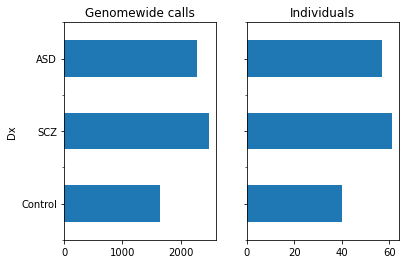

In [5]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, sharey=True)
d['ncalls'].plot(kind='barh', ax=ax[0])
pd.Series(d['nsamples']).plot(kind='barh', ax=ax[1])
ax[0].set_title('Genomewide calls')
ax[1].set_title('Individuals')

## Limitations of the $\chi^2$ test

* univariate: it doesn't allow easy analysis of joint effects of multiple features
* counts of calls are the only possible variable to model

### Example: calls weighted by allele frequency

This piece of analysis shows that weighting each call with its allele frequency decreases significance of the $\chi^2$ test since the $\mathrm{AF} < 1$ (moreover $\mathrm{AF} \ll 1$ for most calls).

In [6]:
wncalls = data.groupby('Dx')['AF'].sum()
wresults = results.drop(('Dx', ), axis=1).astype('int16').apply(lambda x: x * data['AF'], axis=0)
operations.chisquare_summary(summary, expected_odds=wncalls, append=False)

/home/attila/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


chisq stat   chisq p
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                   1.152128  0.562107
                           coding syn                      0.491868  0.781974
                           missense                             NaN       NaN
                           stop-gain                       2.675849  0.262390
                           intronic (splice_site)          1.330329  0.514189
ensembl_Predicted Function coding                          0.288166  0.865816
sift_Prediction            Deleterious                     0.673078  0.714238
                           Deleterious - Low Confidence    0.847928  0.654447
polyphen_Prediction        Probably Damaging               0.472640  0.789528
                           Possibly Damaging               2.006178  0.366745
tfbs_TFBS Name             any                             0.209300  0.900640
phast_Score                any                             3.446117  0.178519
gerp_Element RS Score      any                             7.684747  0.021443
cpg_CpG Island             any                             4.093641  0.129145
near_gens_Overlapped Gene  SCZ GWAS genes                  8.908390  0.011630

## DataFrame for regression: `ncalls_scz_gwas_genes`

In [7]:
df = pd.DataFrame(data.groupby('Individual ID').size(), columns=['ncalls'])
df['ncalls_scz_gwas_genes'] = results[('near_gens_Overlapped Gene', 'SCZ GWAS genes')].groupby('Individual ID').sum()
df['fcalls_scz_gwas_genes'] = df['ncalls_scz_gwas_genes'] / df['ncalls']
selindivcols = ['Dx', 'ageOfDeath']
df[selindivcols] = data[selindivcols].groupby('Individual ID').first()
selcols = ['DP', 'BaseQRankSum', 'AF']
df[selcols] = data[selcols].groupby('Individual ID').mean()
scz_gwas_genes = df
scz_gwas_genes

,ncalls,ncalls_scz_gwas_genes,fcalls_scz_gwas_genes,Dx,ageOfDeath,DP,BaseQRankSum,AF
Individual ID,,,,,,,,
AN02255,21,1,0.047619,ASD,20.0,186.714286,0.919714,0.063810
AN05983,185,2,0.010811,ASD,24.0,215.102703,0.531795,0.027784
AN06365,27,0,0.000000,ASD,10.0,208.592593,-0.069296,0.058519
AN09412,30,1,0.033333,ASD,29.0,265.500000,1.695567,0.076000
AN12434,47,1,0.021277,ASD,18.0,241.234043,0.870851,0.060851
...,...,...,...,...,...,...,...,...
UMB5878,30,0,0.000000,ASD,27.0,269.066667,0.222433,0.055333
UMB5939,24,1,0.041667,ASD,21.0,191.833333,0.798708,0.085833
UMB797,42,0,0.000000,ASD,9.0,200.380952,1.083071,0.031429


### Pairwise joint distributions

* No two variables show extremely tight dependence which implies limited collinearity in a normal or generalized linear model.
* The fraction of calls `fcalls_scz_gwas_genes` has very high variance when the total number of calls for an individual is low. This is undesirable.

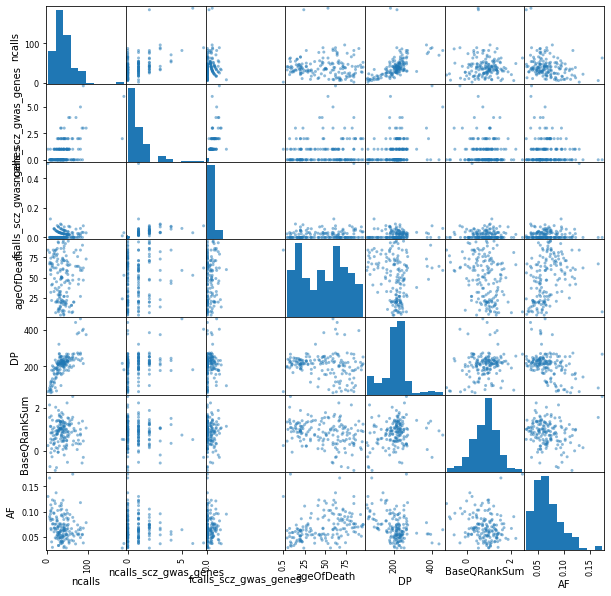

In [8]:
ax = pd.plotting.scatter_matrix(df, figsize=(10, 10))

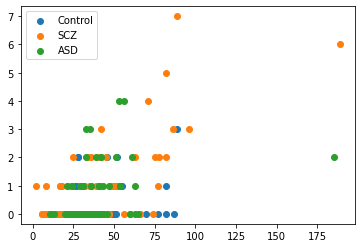

In [9]:
fig, ax = plt.subplots()
for Dx in ['Control', 'SCZ', 'ASD']:
    ax.scatter(x='ncalls', y='ncalls_scz_gwas_genes', data=df.loc[df['Dx'] == Dx], label=Dx)
ax.legend()

In [10]:
Dxs = pd.Categorical(results[('Dx', )].groupby('Individual ID').first(), categories=results[('Dx', )].cat.categories)
Dxcol = Dxs.rename_categories(['C0', 'C1', 'C2'])
responses = results.drop(('Dx',), axis=1).groupby('Individual ID').sum()
prettynames = ['coding_nonsyn', 'coding_syn', 'missense', 'stop_gain', 'splice_site', 'coding', 'deleterious', 'deleterious_low_confidence', 'probably_damaging', 'possibly_damaging', 'tfbs', 'phast', 'gerp', 'cpg_island', 'scz_gwas_genes']
responses.columns = prettynames
covariates = scz_gwas_genes[['ncalls', 'DP', 'AF', 'BaseQRankSum', 'ageOfDeath']]
covariates = pd.concat([covariates['ncalls'].apply(np.log10).rename('log10_ncalls'), covariates], axis=1)

/home/attila/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2878: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/attila/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


## Multiple features/functional categories

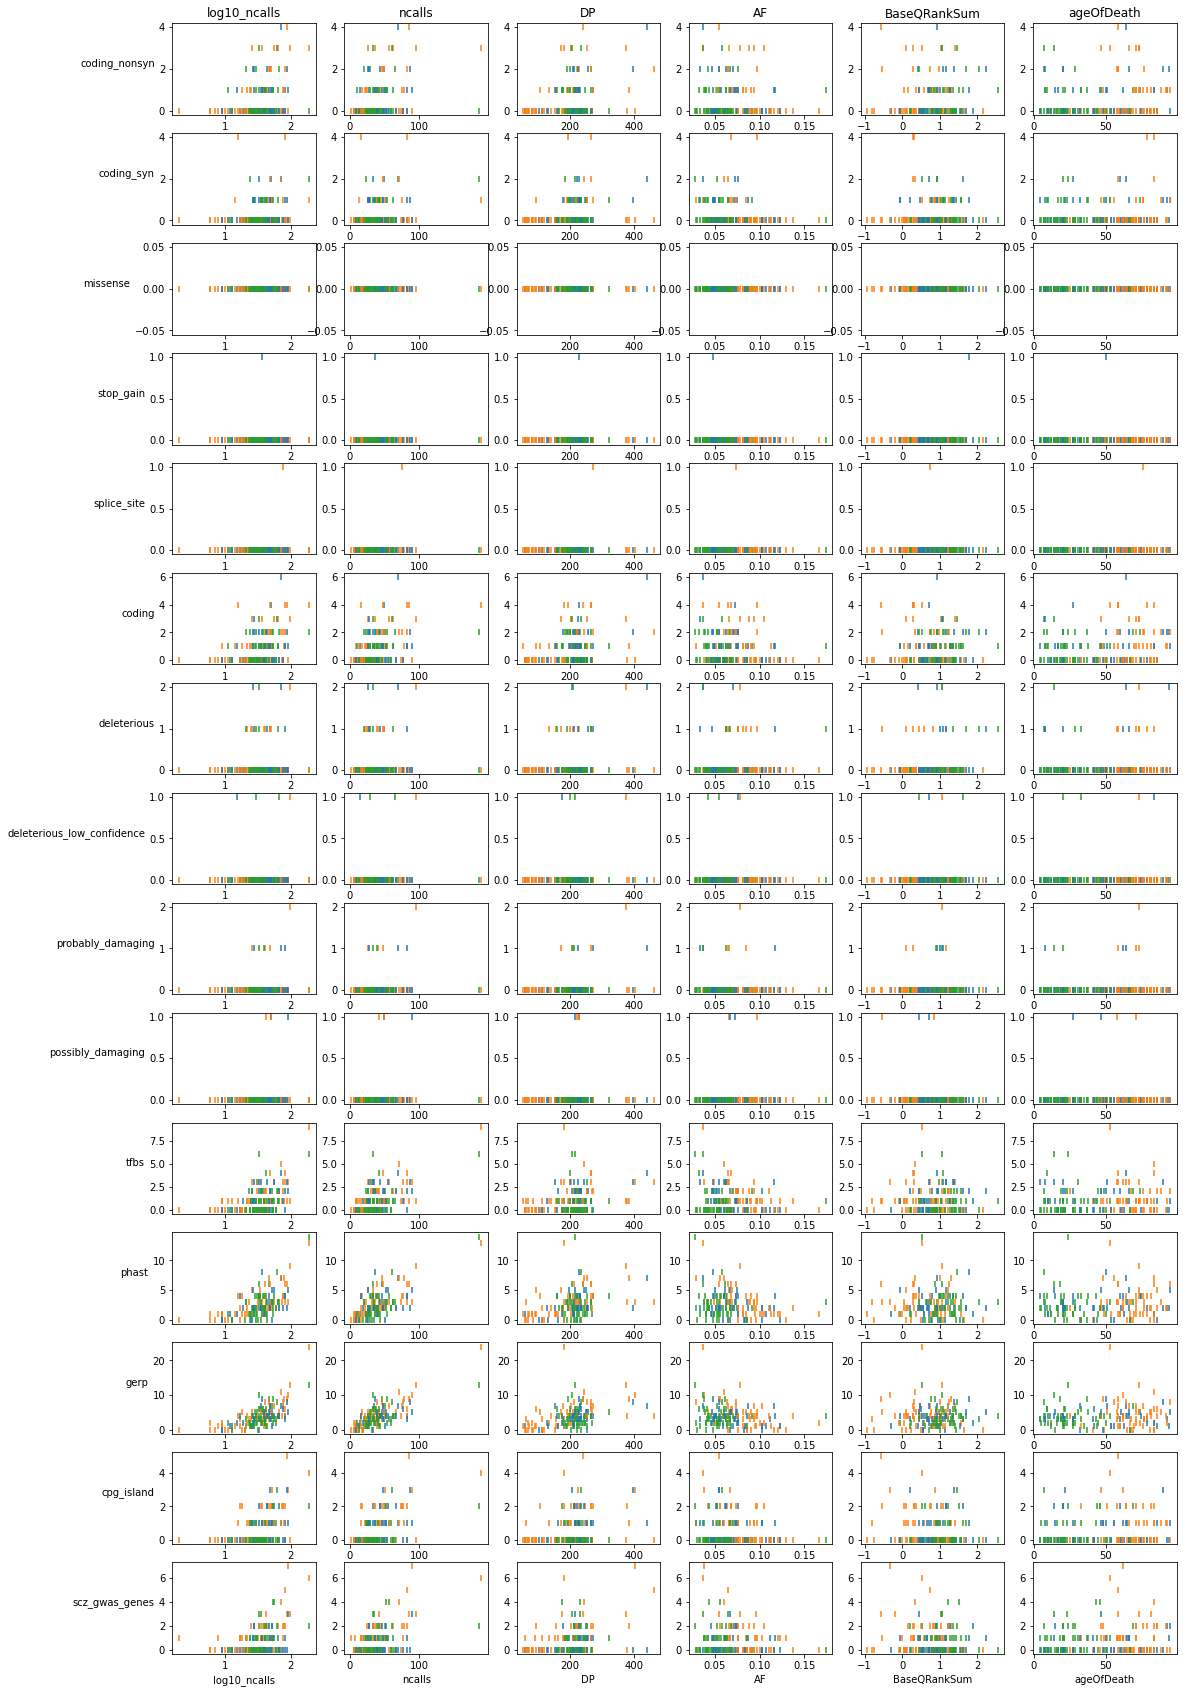

In [11]:
def foo(responses, covariates, Dxcol, dropASD=True):
    if dropASD:
        responses = responses.loc[Dxcol != 'C2']
        covariates = covariates.loc[Dxcol != 'C2']
        Dxcol = Dxcol[Dxcol != 'C2']

    nresp = responses.shape[1]
    ncovar = covariates.shape[1]
    fig, ax = plt.subplots(nresp, ncovar, sharey=False, figsize=(ncovar * 3, nresp * 2))
    for i, row in zip(range(nresp), responses.columns):
        response = responses[row]
        ax[i, 0].set_ylabel(row, rotation='horizontal', horizontalalignment='right')
        for j, col in zip(range(ncovar), covariates.columns):
            if i == 0:
                ax[i, j].set_title(col)
            if i == nresp - 1:
                ax[i, j].set_xlabel(col)
            ax[i, j].scatter(y=response, x=covariates[col], marker='|', c=Dxcol)

foo(responses, covariates, Dxcol, False)

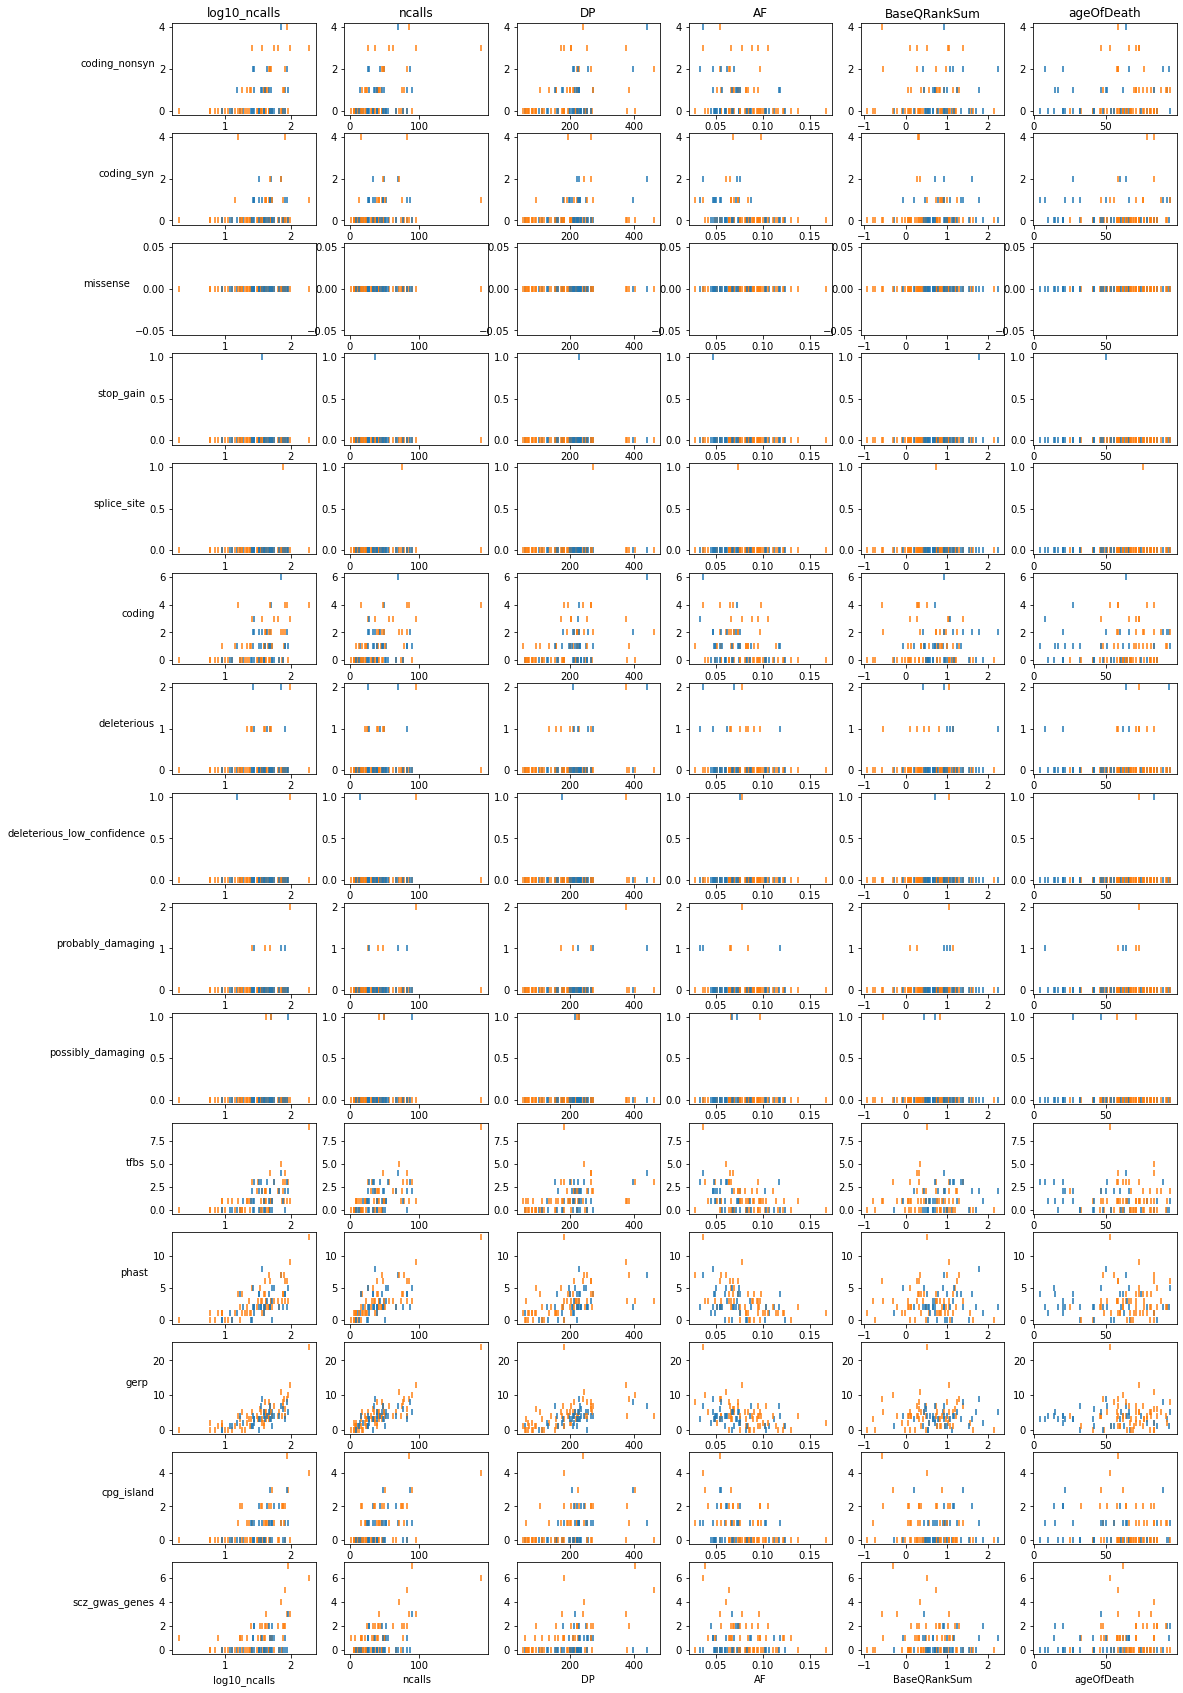

In [12]:
foo(responses, covariates, Dxcol, True)

### More transformations

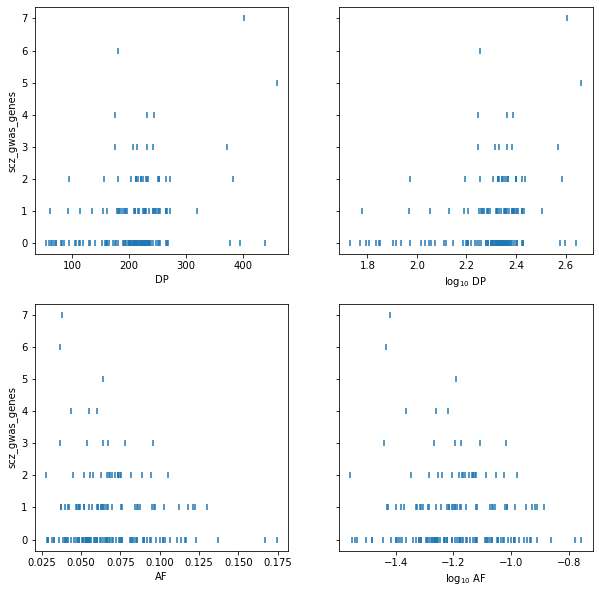

In [13]:
%matplotlib inline
features = ['DP', 'AF']
fig, ax = plt.subplots(len(features), 2, figsize=(10, 10), sharey=True)
for i, feature in zip(range(len(features)), features):
    ax[i, 0].scatter(y=responses['scz_gwas_genes'], x=covariates[feature], marker='|')
    ax[i, 0].set_ylabel('scz_gwas_genes')
    ax[i, 0].set_xlabel(feature)
    ax[i, 1].scatter(y=responses['scz_gwas_genes'], x=np.log10(covariates[feature]), marker='|')
    ax[i, 1].set_xlabel('$\log_{10}$ ' + feature)

## Fitting models

### Training data
First simplify column names and create data matrix

In [14]:
fitdata = pd.concat([responses, covariates], axis=1)
fitdata['Dx'] = Dxs
endog = responses
exog0 = fitdata.drop(prettynames + ['ncalls'], axis=1)
exog1 = fitdata.drop(prettynames + ['log10_ncalls'], axis=1)

In [15]:
def endog_binomial(feature, fitdata=fitdata, proportion=False):
    success = fitdata[feature]
    if proportion:
        prop = success / fitdata['ncalls']
        return(prop)
    failure = fitdata['ncalls'] - success
    complement = 'NOT_' + feature
    df = pd.DataFrame({feature: success, complement: failure})
    return(df)

### Log linear (Poisson) models

In [16]:
formula = 'scz_gwas_genes ~ Dx'
y0, X0 = patsy.dmatrices(formula, data=fitdata, return_type='dataframe')
pois0 = sm.GLM(endog=y0, exog=X0, family=sm.families.Poisson()).fit()

In [17]:
formula = 'scz_gwas_genes ~ Dx + log10_ncalls'
y1, X1 = patsy.dmatrices(formula, data=fitdata, return_type='dataframe')
pois1 = sm.GLM(endog=y1, exog=X1, family=sm.families.Poisson()).fit()

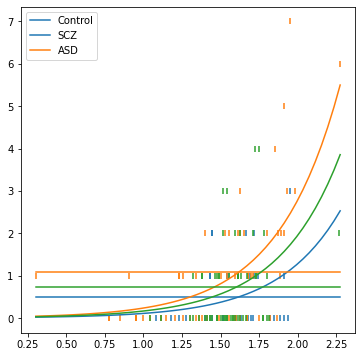

In [18]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 6))
left = fitdata['log10_ncalls'].min()
right = fitdata['log10_ncalls'].max()
log10_ncalls_test = np.linspace(left, right)
Dxd = {'Control': (0, 0), 'SCZ': (1, 0), 'ASD': (0, 1)}
for color, Dx in zip(['C0', 'C1', 'C2'], fitdata['Dx'].cat.categories):
    y0_pred = pois0.predict([1, *Dxd[Dx]])
    ax.plot([left, right], [y0_pred] * 2, linestyle='solid', label=Dx + '0')
    X_test = pd.DataFrame(dict(zip(X1.columns, [1, *Dxd[Dx], log10_ncalls_test])))
    ax.scatter(x='log10_ncalls', y='scz_gwas_genes', data=fitdata.loc[fitdata['Dx'] == Dx], marker='|', color=color)
    ax.plot(log10_ncalls_test, pois1.predict(X_test), color=color, label=Dx)
ax.legend(Dxd.keys())

(0.0, 10.0)

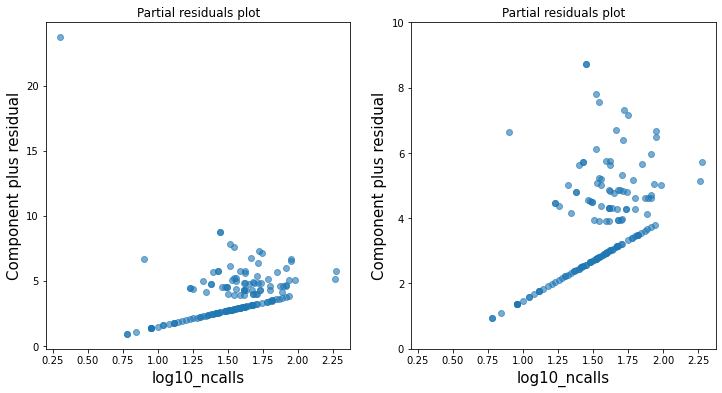

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
g = pois1.plot_partial_residuals('log10_ncalls', ax=ax[0])
g = pois1.plot_partial_residuals('log10_ncalls', ax=ax[1])
ax[1].set_ylim(0, 10)

### Poisson model results

In [20]:
formula = 'scz_gwas_genes ~ Dx + log10_ncalls + DP'
y2, X2 = patsy.dmatrices(formula, data=fitdata, return_type='dataframe')
pois2 = sm.GLM(endog=y2, exog=X2, family=sm.families.Poisson()).fit()

In [21]:
formula = 'scz_gwas_genes ~ Dx + log10_ncalls + np.log(DP)'
y2b, X2b = patsy.dmatrices(formula, data=fitdata, return_type='dataframe')
pois2b = sm.GLM(endog=y2b, exog=X2b, family=sm.families.Poisson()).fit()

In [22]:
pd.DataFrame({'pois2': pois2.deviance, 'pois2b': pois2b.deviance}, index=['deviance'])

,pois2,pois2b
deviance,179.670886,180.072769


In [23]:
pd.DataFrame({'pois2': pois2.pvalues, 'pois2b': pois2b.pvalues})

,pois2,pois2b
DP,2.963626e-01,NaN
Dx[T.ASD],1.028625e-01,1.125999e-01
Dx[T.SCZ],2.166283e-03,1.964252e-03
Intercept,1.499921e-13,2.521607e-04
log10_ncalls,1.357843e-08,3.850942e-08
np.log(DP),NaN,4.175663e-01


In [24]:
formula = 'scz_gwas_genes ~ Dx + log10_ncalls + DP + AF'
y, X = patsy.dmatrices(formula, data=fitdata, return_type='dataframe')
pois = sm.GLM(endog=y, exog=X, family=sm.families.Poisson()).fit()
pois.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         scz_gwas_genes   No. Observations:                  158
Model:                            GLM   Df Residuals:                      152
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -175.31
Date:                Sun, 14 Feb 2021   Deviance:                       179.65
Time:                        20:28:20   Pearson chi2:                     190.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.6565      0.834     -5.585      0.000      -6.291      -3.022
Dx[T.SCZ]        0.7877      0.257      3.068      0.002       0.284       1.291
Dx[T.ASD]        0.4368      0.280      1.561      0.119      -0.112       0.985
log10_ncalls     2.2666      0.425      5.334      0.000       1.434       3.099
DP               0.0014      0.001      1.035      0.301      -0.001       0.004
AF              -0.5795      4.159     -0.139      0.889      -8.732       7.573
================================================================================
"""

### Logistic (binomial) model

In [25]:
formula = 'Dx + DP + AF'
X = patsy.dmatrix(formula, data=fitdata, return_type='dataframe')

Response can be given as either:
1. counts of both success and failure
1. proportions

In [26]:
success_failure = endog_binomial('scz_gwas_genes', fitdata, False)
proportion = endog_binomial('scz_gwas_genes', fitdata, proportion=True)
pd.concat([success_failure, proportion, fitdata['ncalls']], axis=1).rename({0: 'proportion'}, axis=1)

,scz_gwas_genes,NOT_scz_gwas_genes,proportion,ncalls
Individual ID,,,,
AN02255,1,20,0.047619,21
AN05983,2,183,0.010811,185
AN06365,0,27,0.000000,27
AN09412,1,29,0.033333,30
AN12434,1,46,0.021277,47
...,...,...,...,...
UMB5878,0,30,0.000000,30
UMB5939,1,23,0.041667,24
UMB797,0,42,0.000000,42


When using proportion type response then the total number of calls `fitdata['ncalls']` must be passed as `var_weights` to `GLM`.  Note that the two fits result in the same parameter estimates.

In [27]:
# Method: response is a success failure pair
mod = sm.GLM(endog=success_failure, exog=X, family=sm.families.Binomial()).fit()
# Method 2: response is a proportion; var_weights must be specified
mod_p = sm.GLM(endog=proportion, exog=X, family=sm.families.Binomial(), var_weights=fitdata['ncalls']).fit()
# Check if parameter estimates are identical
all(mod.params == mod_p.params)

True

In [28]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Generalized Linear Model Regression Results                             
====================================================================================================
Dep. Variable:     ['scz_gwas_genes', 'NOT_scz_gwas_genes']   No. Observations:                  158
Model:                                                  GLM   Df Residuals:                      153
Model Family:                                      Binomial   Df Model:                            4
Link Function:                                        logit   Scale:                          1.0000
Method:                                                IRLS   Log-Likelihood:                -175.48
Date:                                      Sun, 14 Feb 2021   Deviance:                       183.53
Time:                                              20:28:20   Pearson chi2:                     195.
No. Iterations:                                           7                                         
Covariance Type:                                  nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7089      0.505     -9.332      0.000      -5.698      -3.720
Dx[T.SCZ]      0.8006      0.258      3.108      0.002       0.296       1.305
Dx[T.ASD]      0.4454      0.281      1.584      0.113      -0.106       0.996
DP             0.0014      0.001      1.113      0.266      -0.001       0.004
AF            -0.4744      3.960     -0.120      0.905      -8.235       7.287
==============================================================================
"""

In [29]:
def fitmod(endogname='coding_nonsyn', exog=exog0):
    formula = endogname + ' ~ ' + ' + '.join(exog.columns)
    y, X = patsy.dmatrices(formula, data=fitdata, return_type='dataframe')
    mod = sm.GLM(endog=y, exog=X, family=sm.families.Poisson()).fit()
    return(mod)

In [30]:
endognames = ['coding_nonsyn', 'coding_syn', 'coding', 'deleterious', 'deleterious_low_confidence', 'probably_damaging', 'possibly_damaging', 'tfbs', 'phast', 'gerp', 'cpg_island', 'scz_gwas_genes']
modA, modB = ({endogname: fitmod(endogname, exog) for endogname in endognames} for exog in [exog0, exog1])

In [31]:
modA['scz_gwas_genes'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         scz_gwas_genes   No. Observations:                  158
Model:                            GLM   Df Residuals:                      150
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -174.06
Date:                Sun, 14 Feb 2021   Deviance:                       177.15
Time:                        20:28:21   Pearson chi2:                     187.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.0156      0.917     -5.467      0.000      -6.814      -3.218
Dx[T.SCZ]        0.6103      0.281      2.175      0.030       0.060       1.160
Dx[T.ASD]        0.6406      0.315      2.036      0.042       0.024       1.257
log10_ncalls     2.3008      0.433      5.314      0.000       1.452       3.149
DP               0.0015      0.001      1.056      0.291      -0.001       0.004
AF              -0.3657      4.438     -0.082      0.934      -9.064       8.333
BaseQRankSum    -0.1175      0.180     -0.653      0.513      -0.470       0.235
ageOfDeath       0.0076      0.005      1.467      0.142      -0.003       0.018
================================================================================
"""

In [32]:
modB['scz_gwas_genes'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         scz_gwas_genes   No. Observations:                  158
Model:                            GLM   Df Residuals:                      150
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -175.67
Date:                Sun, 14 Feb 2021   Deviance:                       180.37
Time:                        20:28:21   Pearson chi2:                     179.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.4746      0.623     -3.974      0.000      -3.695      -1.254
Dx[T.SCZ]        0.5721      0.277      2.062      0.039       0.028       1.116
Dx[T.ASD]        0.6455      0.320      2.019      0.044       0.019       1.272
ncalls           0.0133      0.002      5.540      0.000       0.009       0.018
DP               0.0036      0.001      3.109      0.002       0.001       0.006
AF               0.3326      4.497      0.074      0.941      -8.481       9.146
BaseQRankSum    -0.1196      0.178     -0.671      0.502      -0.469       0.230
ageOfDeath       0.0078      0.005      1.495      0.135      -0.002       0.018
================================================================================
"""

### Partial residual plots

See [this lecture note](http://www.econ.uiuc.edu/~roger/courses/471/lectures/L4.pdf) on partial residual analysis.

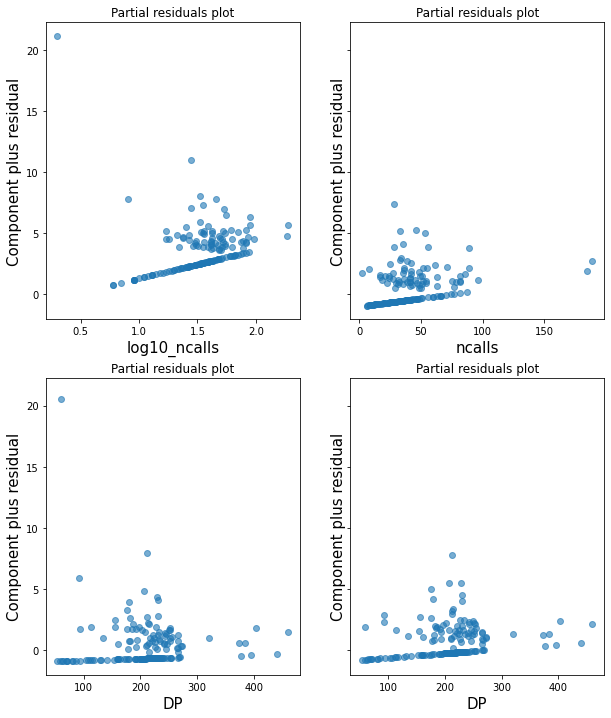

In [33]:
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(10, 12))
g = modA['scz_gwas_genes'].plot_partial_residuals('log10_ncalls', ax=ax[0, 0])
g = modB['scz_gwas_genes'].plot_partial_residuals('ncalls', ax=ax[0, 1])
g = modA['scz_gwas_genes'].plot_partial_residuals('DP', ax=ax[1, 0])
g = modB['scz_gwas_genes'].plot_partial_residuals('DP', ax=ax[1, 1])

In [34]:
%connect_info

{
  "shell_port": 55011,
  "iopub_port": 38077,
  "stdin_port": 39267,
  "control_port": 38171,
  "hb_port": 36719,
  "ip": "127.0.0.1",
  "key": "636f6fec-dbf9c02a54e11dadf9920efd",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-41d9ed77-0abb-4ba0-8326-88f4b1a395c1.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
